# Grab & Upload Files

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Set our path
path = '/content/drive/My Drive/training/dataset'

# U-Net

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os

# # Make only selected GPUs visible 
# os.environ["CUDA_VISIBLE_DEVICES"]="3"

import glob
import random
from keras.models import *

from keras.layers import Input, merge, Conv2D, MaxPooling2D
from keras.layers import UpSampling2D, Dropout, Cropping2D, Concatenate, BatchNormalization

from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

from keras.preprocessing.image import img_to_array, load_img

Using TensorFlow backend.


In [0]:
# Assummed directory structure 
# 
# +- images 
# |
# +- masks +- 0
#           +- 1
#           ...
#           +- n
# 
# Number of labels is determined by presence of subdirectories in "masks". 

# Mac/Linux
image_dir = '/content/drive/My Drive/training/dataset/images'
labels_dir = '/content/drive/My Drive/training/dataset/masks'

# Windows
# image_dir = 'C:\\Users\\Honson\\Desktop\\notebook\\catheterLabels\\set1\\images'
# labels_dir = 'C:\\Users\\Honson\\Desktop\\notebook\\catheterLabels\\set1\\masks'

# Google Colab
# same as linux

# Change resolution image accordingly
height = 512
width = 512
color_space = "grayscale" # "grayscale" or "rgb"

# Set number of input channels based on the selected colorspace
if color_space == "grayscale":
    n_channels = 1
elif color_space == "rgb":
    n_channels = 3

# Get parameters of the input and output from images and labels 
images = glob.glob(image_dir+'/*')
labels = glob.glob(labels_dir+'/*')
print(labels)

n_images = len(images)
n_classes = len(labels)

print('Number of images : ', n_images)
print('Number of channels : ', n_channels)
print('Number of classes :', n_classes)
print('Image height : ', height)
print('Image width :', width)

data_images = np.ndarray((n_images, height, width, n_channels), dtype=np.uint8)
data_labels = np.ndarray((n_images, height, width, n_classes), dtype=np.uint8)

print(data_images.shape)
print(data_labels.shape)

idx = 0
for i in images:
    
    # Read image
    fn = i
    
    # Convert to desired color space 
    img = load_img(fn, color_mode = color_space, target_size=(height, width))
    img = img_to_array(img)

    # Put in the data_images array
    data_images[idx] = img
    
    # Look for labels for this image, read and put in the data_labels array
    # Take note that this starts from 0 and goes to n. The labels must be labeled in this sense.
    for j in range(0, n_classes):

        img_fn = fn.split('/')[-1]
        
        # label_fn = labels_dir+'/'+str(j)+'/'+img_fn
        label_fn = labels_dir+'/'+str(1)+'/'+img_fn # fixed because we started with 1
        #print('Our label fn is:')
        #print(label_fn)
        
        # If file label_fn exists read
        if os.path.exists(label_fn):
            
            label = load_img(label_fn, color_mode = "grayscale", target_size=(height, width))
            label = img_to_array(label)
            label = np.reshape(label, (height, width))
        
            data_labels[idx,:,:,j] = label
            
        else:
            data_labels[idx,:,:,j] = 0
    
    idx = idx + 1

    
data_images = data_images.astype('float32')
data_labels = data_labels.astype('float32')
data_images /= 255
data_labels /= 255
data_labels[data_labels > 0.5] = 1
data_labels[data_labels <= 0.5] = 0

['/content/drive/My Drive/training/dataset/masks/1']
Number of images :  240
Number of channels :  1
Number of classes : 1
Image height :  512
Image width : 512
(240, 512, 512, 1)
(240, 512, 512, 1)


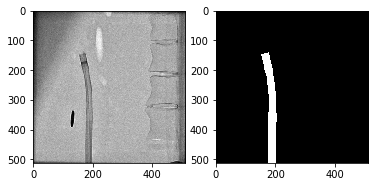

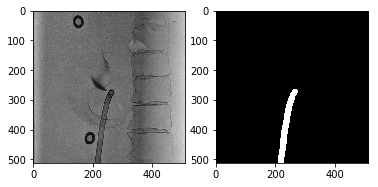

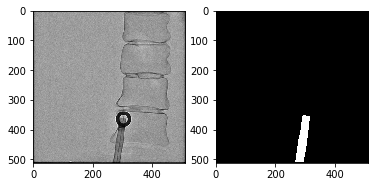

In [0]:
# Plot sample labels and images 
n_samples = 3
for j in range(0,n_samples):
    
    test_image_idx = random.randint(0,n_images-1)
    
    f = plt.figure()
    
    f.add_subplot(1,n_classes+1, 1) # image forst
    plt.imshow(data_images[test_image_idx,:,:,0],'gray')
    
    # Loop over classes
    for k in range(0,n_classes):
        
        f.add_subplot(1,n_classes+1, k+2)
        plt.imshow(data_labels[test_image_idx,:,:,k],'gray')
        

    plt.show(block=True)


In [0]:
# Define the U-net network 

def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
    if depth > 0:
        n = conv_block(m, dim, acti, bn, res)
        m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
        m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)
        if up:
            m = UpSampling2D()(m)
            m = Conv2D(dim, 2, activation=acti, padding='same')(m)
        else:
            m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
        n = Concatenate()([n, m])
        m = conv_block(n, dim, acti, bn, res)
    else:
        m = conv_block(m, dim, acti, bn, res, do)
    return m

def conv_block(m, dim, acti, bn, res, do=0):
    n = Conv2D(dim, 3, activation=acti, padding='same')(m)
    n = BatchNormalization()(n) if bn else n
    n = Dropout(do)(n) if do else n
    n = Conv2D(dim, 3, activation=acti, padding='same')(n)
    n = BatchNormalization()(n) if bn else n
    return Concatenate()([m, n]) if res else n

def unet(img_shape, out_ch=1, start_ch=64, depth=4, inc_rate=2., activation='relu', 
         dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=False):
    
    i = Input(shape=img_shape)
    o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
    o = Conv2D(out_ch, 1, activation='sigmoid')(o)
    
    model = Model(inputs=i, outputs=o)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

    return model

In [0]:
model = unet((height, width, n_channels), 
             out_ch=n_classes, 
             depth=4, 
             inc_rate=2., 
             activation="relu", 
             dropout=True, 
             batchnorm=False, 
             maxpool=True, 
             upconv=True, 
             residual=False)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
from keras.callbacks import ModelCheckpoint

model_checkpoint = ModelCheckpoint('unet.hdf5', monitor='loss', verbose=1, save_best_only=True)
print('Fitting model...')

history = model.fit(data_images, 
          data_labels, 
          batch_size=1, 
          epochs=20, 
          verbose=1,
          validation_split=0.2, 
          shuffle=True, 
          callbacks=[model_checkpoint])

model_file = "/content/drive/My Drive/training/model/catheter-detect.h5"
print("Saving model file in ", model_file)
model.save(model_file)

Fitting model...

Train on 192 samples, validate on 48 samples
Epoch 1/20
192/192 [==============================] - 76s 398ms/step - loss: 0.1252 - acc: 0.9667 - val_loss: 0.0261 - val_acc: 0.9912

Epoch 00001: loss improved from inf to 0.12517, saving model to unet.hdf5
Epoch 2/20
192/192 [==============================] - 62s 324ms/step - loss: 0.0149 - acc: 0.9946 - val_loss: 0.0107 - val_acc: 0.9960

Epoch 00002: loss improved from 0.12517 to 0.01488, saving model to unet.hdf5
Epoch 3/20
192/192 [==============================] - 63s 330ms/step - loss: 0.0088 - acc: 0.9965 - val_loss: 0.0065 - val_acc: 0.9973

Epoch 00003: loss improved from 0.01488 to 0.00884, saving model to unet.hdf5
Epoch 4/20
192/192 [==============================] - 64s 335ms/step - loss: 0.0074 - acc: 0.9970 - val_loss: 0.0070 - val_acc: 0.9969

Epoch 00004: loss improved from 0.00884 to 0.00736, saving model to unet.hdf5
Epoch 5/20
192/192 [==============================] - 65s 337ms/step - loss: 0.0066 -

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


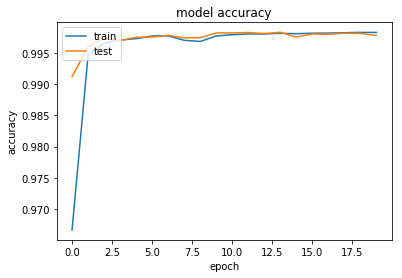

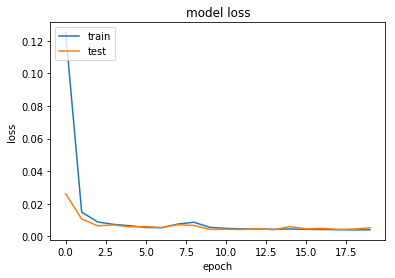

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
# Validation 

inference_model = unet((height, width, n_channels), 
                       out_ch=n_classes, 
                       depth=4, 
                       inc_rate=2., 
                       activation="relu", 
                       dropout=True, 
                       batchnorm=False, 
                       maxpool=True, 
                       upconv=True, 
                       residual=False)
inference_model.load_weights('/content/drive/My Drive/training/model/catheter-detect.h5')

In [0]:
# Runs Inference
n = 1

test_image_idx = random.randint(0,n_images)
print(test_image_idx)
test_image = images[test_image_idx]

test_data = np.ndarray((n, height, width, n_channels), dtype=np.uint8)
img = load_img(test_image, color_mode = color_space, target_size=(height, width))

img = img_to_array(img)

test_data[0] = img

# Convert to float and normalize
test_data = test_data.astype('float32')
test_data /= 255

print("running test inference")
img_mask = inference_model.predict(test_data, batch_size=1, verbose=1)
print(img_mask.shape)
print("test ok")

100
running test inference
1/1 [==============================] - 0s 270ms/step
(1, 512, 512, 1)
test ok


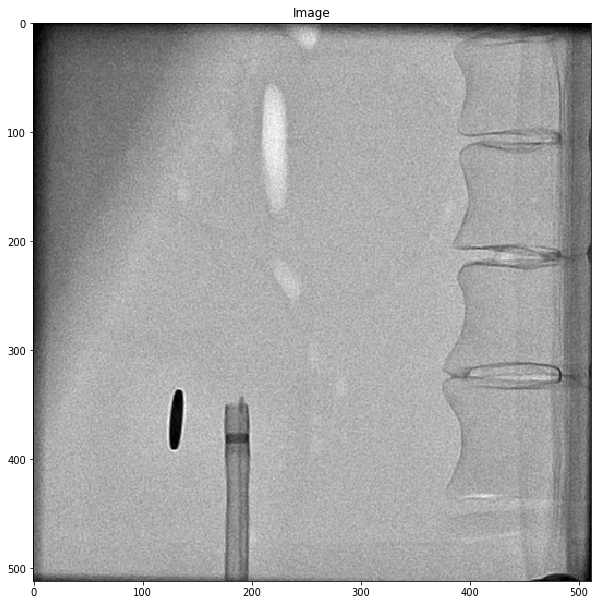

Model output
Our n classes is  1


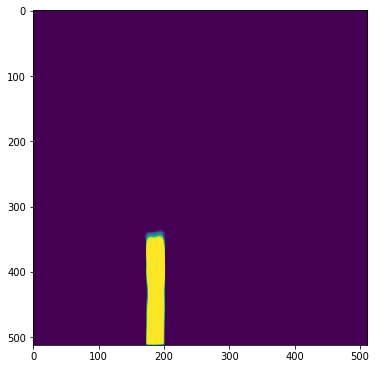

Ground truth


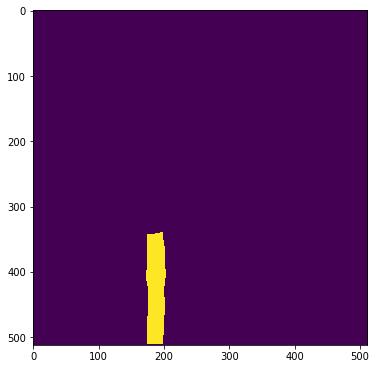

In [0]:
# Loads and tests random image from trained model

import math

img_per_row = 3
n_rows = math.ceil(n_classes/img_per_row) + 1

plt.rcParams["figure.figsize"] = (10,20)
plt.title('Image')
plt.imshow(test_data[0,:,:,0], "gray")
plt.show()

# Threshold 
# threshold = 0.5
# img_mask[img_mask > threshold] = 1
# img_mask[img_mask <= threshold] = 0

print('Model output')

plt.rcParams["figure.figsize"] = (15,30)
f1 = plt.figure()

# Loop over classes
print('Our n classes is ', n_classes)
for k in range(0,n_classes):

    f1.add_subplot(n_rows, img_per_row, k+1)
    plt.imshow(img_mask[0,:,:,k])

plt.tight_layout()
plt.show()


print('Ground truth')

plt.rcParams["figure.figsize"] = (15,30)
f2 = plt.figure()

# Loop over classes
for k in range(0,n_classes):

    f2.add_subplot(n_rows, img_per_row, k+1)
    plt.imshow(data_labels[test_image_idx,:,:,k])

plt.tight_layout()
plt.show()

In [0]:
from keras.utils import print_summary, plot_model

#plot_model(model, to_file='unet-model.png', show_shapes=False, show_layer_names=True, rankdir='TB')
print_summary(model)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 256, 256, 64) 0           conv2d_2[0][0]                   
____________________________________________________________________________________________